# 3D Inversion of Time-domain Electromagnetic Synthesized Data Using SimPEG
## Bo Ouyang, Ke Wang, Dikun Yang (SUSTech)

### This tutorial provides a template of 3D inversion of a TEM synthesized data

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorms
import numpy as np
import SimPEG.electromagnetics.time_domain as TDEM
from discretize import TensorMesh
from SimPEG import (data_misfit, directives, inverse_problem, inversion, maps,
                    optimization, regularization, simulation, utils, data)

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

In [3]:
# create a 3d tensor mesh for forward simulation
cs, ncx, ncy, ncz, npad = 20., 20, 30, 10, 13
pad_rate = 1.3
hx = [(cs,npad,-pad_rate), (cs,ncx), (cs,npad,pad_rate)]
hy = [(cs,npad,-pad_rate), (cs,ncy), (cs,npad,pad_rate)]
hz = [(cs,npad,-pad_rate), (cs,ncz), (cs,npad,pad_rate)]
mesh = TensorMesh([hx,hy,hz], 'CCC')

# conductivity model parameters
sig_air = 1e-8

# mapping model
actind = mesh.gridCC[:,2]<0.
actmap = maps.InjectActiveCells(mesh, indActive=actind, valInactive=np.log(sig_air))
expmap = maps.ExpMap(mesh)
mapping = maps.ComboMap([expmap, actmap])

# initial & reference model
sig0 = 1e-2
mref = np.log(sig0)*np.ones(actmap.nP)
m0 = mref.copy()

In [14]:
# assemble the sources and receivers
time = np.logspace(np.log10(1e-4), np.log10(1e-2), 7)# time channel

x = np.linspace(-300., 300., 10)
y = np.linspace(-450., 450., 15)

srcList = []# source list

# Option 1: line current source
location_r = np.zeros((len(y)*len(x),3))# receiver locations
location_s = np.array([[160,-240,0],[160,240,0],[-160,240,0],[-160,-240,0],[160,-240,0]])# source location

for iy in range(len(y)):
    for ix in range(len(x)):
        location_r[np.int(iy)*np.int(len(x))+np.int(ix),:] = np.array([[x[ix], y[iy], 0.]])# receiver locations

rx_z = TDEM.receivers.PointMagneticFluxTimeDerivative(location_r, time, 'z')
src = TDEM.sources.LineCurrent([rx_z], loc=location_s)
srcList.append(src)

# Option 2: circular loop source
# for iy in y:
   # for ix in x:
       # location = np.array([[ix, iy, 30.]])
       # rx_z = TDEM.receivers.PointMagneticFluxTimeDerivative(location, time, 'z')
       # src = TDEM.sources.CircularLoop([rx_z], orientation='z', location=location)
       # srcList.append(src)

In [16]:
# set up for the forward simulation
timesteps = [(1e-4/15, 15), (1e-4*0.75, 10), (1e-3*0.75, 15)]

survey = TDEM.Survey(srcList)
sim = TDEM.simulation.Simulation3DElectricField(mesh, Solver=Solver, verbose=True, timeSteps=timesteps, sigmaMap=mapping, survey=survey)

# set up data object
dobs = np.load('./data/dobs_linecurrent.npy')# for option 1
# dobs = np.load('./data/dobs_circularloop.npy')# for option 2
dobs = dobs.reshape((survey.nSrc, time.size, rx_z.locs[:,0].size))
dobs = dobs.flatten()

data = data.Data(survey, dobs=dobs, relative_error=0.05, noise_floor=1e-16)

survey.std = 0.05
survey.eps = 1e-16

In [5]:
# inversion
dmisfit = data_misfit.L2DataMisfit(simulation=sim, data=data)
reg = regularization.Tikhonov(
    mesh, alpha_s=1e-7, alpha_x=1., alpha_y=1., alpha_z=1.,
    indActive=actind
)
opt = optimization.InexactGaussNewton(maxIter=20, LSshorten=0.5)
opt.remember('xc')
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)
# Create an inversion object
beta = directives.BetaSchedule(coolingFactor=5, coolingRate=3)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1.)
target=directives.TargetMisfit()
save_model = directives.SaveModelEveryIteration()
save = directives.SaveOutputEveryIteration()

inv = inversion.BaseInversion(invProb, directiveList=[beta, betaest, target, save_model, save])
sim.counter = opt.counter = utils.Counter()
reg.mref = mref
mopt = inv.run(m0)

np.save('./data/mopt_linecurrent', mopt)
np.save('./data/dpred_linecurrent', invProb.dpred)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
Calculating Initial fields
Factoring the system matrix for the DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 6.666667e-06)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
Factoring.

Done...
    Solving...   (tInd = 23)
    Done...
    Solving...   (tInd = 24)
    Done...
    Solving...   (tInd = 25)
    Done...
Factoring...   (dt = 7.500000e-04)
Done
    Solving...   (tInd = 26)
    Done...
    Solving...   (tInd = 27)
    Done...
    Solving...   (tInd = 28)
    Done...
    Solving...   (tInd = 29)
    Done...
    Solving...   (tInd = 30)
    Done...
    Solving...   (tInd = 31)
    Done...
    Solving...   (tInd = 32)
    Done...
    Solving...   (tInd = 33)
    Done...
    Solving...   (tInd = 34)
    Done...
    Solving...   (tInd = 35)
    Done...
    Solving...   (tInd = 36)
    Done...
    Solving...   (tInd = 37)
    Done...
    Solving...   (tInd = 38)
    Done...
    Solving...   (tInd = 39)
    Done...
    Solving...   (tInd = 40)
    Done...
**************************************************
Done calculating fields(m)
**************************************************
   3  9.53e-01  1.34e+05  7.32e+02  1.34e+05    5.79e+04      0   Skip BFGS  
Calcula

Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
Factoring...   (dt = 7.500000e-05)
Done
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    Done...
    Solving...   (tInd = 20)
    Done...
    Solving...   (tInd = 21)
    Done...
    Solving...   (tInd = 22)
    Done...
    Solving...   (tInd = 23)
    Done...
    Solving...   (tInd = 24)
    Done...
    Solving...   (tInd = 25)
    Done...
Factoring...   (dt = 7.500000e-04)
Done
    Solving...   (tInd = 26)
    Done...
    Solving...   (tInd = 27)
    Done...
    Solving...   (tInd = 28)
    Done...
    Solving...   (tInd = 29)
    Done...
    Solving...   (tInd = 30)
    Done...
    Solving...   (tInd = 31)
    Done...
    Solving...   (tInd = 32)
    Done...
    Solving...   (tInd = 33)
    Done...
    Solving...   (tInd = 34)
    Done...
    Solving...   (tInd = 35)
    Done...
    Solvin

Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
Factoring...   (dt = 7.500000e-05)
Done
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    Done...
    Solving...   (tInd = 20)
    Done...
    Solving...   (tInd = 21)
    Done...
    Solving...   (tInd = 22)
    Done...
    Solving...   (tInd = 23)
    Done...
    Solving...   (tInd = 24)
    Done...
    Solving...   (tInd = 25)
    Done...
Factoring...   (dt = 7.500000e-04)
Done
    Solving...  

14  7.62e-03  1.35e+04  3.24e+03  1.36e+04    1.87e+04      0              
Calculating Initial fields
Factoring the system matrix for the DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 6.666667e-06)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
Factoring...   (dt = 7.500000e-05)
Done
    Solving...   (tInd = 16)
    Done...

Done...
    Solving...   (tInd = 35)
    Done...
    Solving...   (tInd = 36)
    Done...
    Solving...   (tInd = 37)
    Done...
    Solving...   (tInd = 38)
    Done...
    Solving...   (tInd = 39)
    Done...
    Solving...   (tInd = 40)
    Done...
**************************************************
Done calculating fields(m)
**************************************************
  18  3.05e-04  1.02e+04  3.37e+03  1.02e+04    1.25e+04      0              
Calculating Initial fields
Factoring the system matrix for the DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 6.666667e-06)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tIn

### Original Model

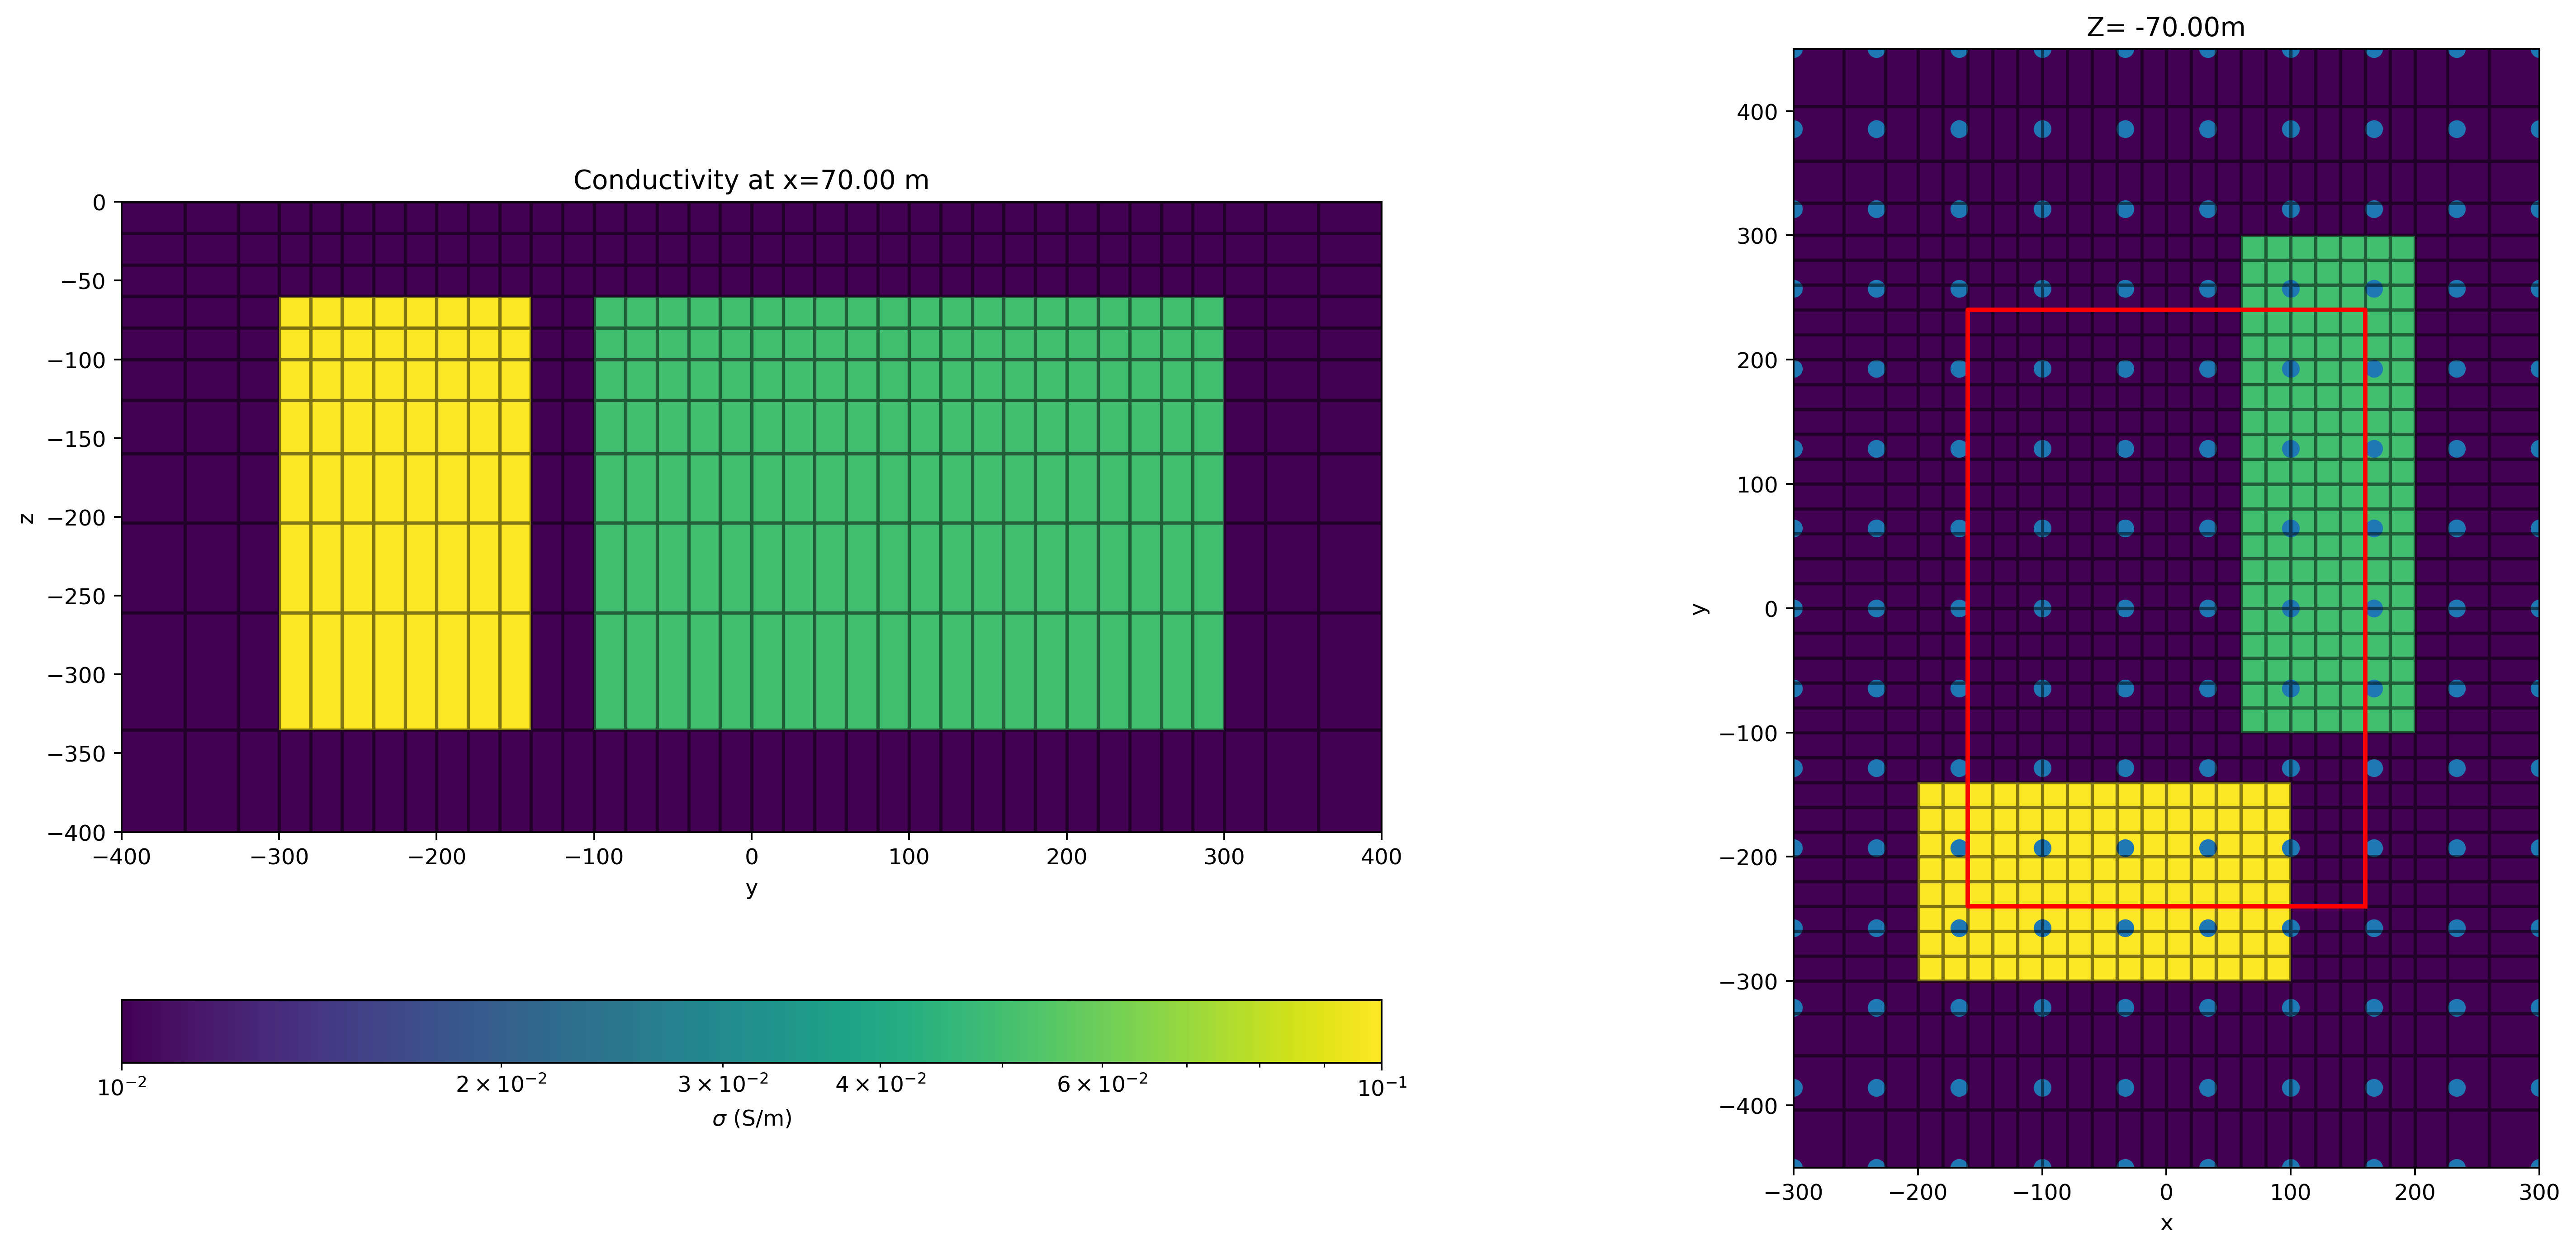

In [4]:
# plot original model

# model parameters
sig_blk1 = 0.1
sig_blk2 = 0.05
sig_ha = 0.01
sig_air = 1e-8

sigma = np.ones(mesh.nC)*sig_air
sigma[mesh.gridCC[:,2]<0.] = sig_ha

blk1 = utils.ModelBuilder.getIndicesBlock(
    np.r_[-200, -140, -60],
    np.r_[100, -300, -300], 
    mesh.gridCC
)
blk2 = utils.ModelBuilder.getIndicesBlock(
    np.r_[60, 300, -60],
    np.r_[200, -100, -300], 
    mesh.gridCC
)
sigma[blk1] = sig_blk1
sigma[blk2] = sig_blk2

indx = 26
indy = 15
indz = 14

fig, ax = plt.subplots(1,2, figsize = (18, 8),dpi=350)

clim = [1e-2, 1e-1]

dat1 = mesh.plotSlice(sigma, grid=True, ax=ax[0], ind=indx, normal='X' ,pcolorOpts={'norm':LogNorm()}, clim=clim)
dat2 = mesh.plotSlice(sigma, grid=True, ax=ax[1], ind=indz, pcolorOpts={'norm':LogNorm()}, clim=clim)

x = np.linspace(-300., 300., 10)
y = np.linspace(-450., 450., 15)
X,Y = np.meshgrid(x,y)

fram = np.array([[160,160,-160,-160,160],[-240,240,240,-240,-240]])
ax[1].plot(fram[0,:],fram[1,:],color='red',linewidth=2)
ax[1].scatter(X,Y,marker='.',s=200)

cb = plt.colorbar(dat1[0], orientation="horizontal", ax = ax[0])

ax[0].set_xlim([-400,400])
ax[0].set_ylim([-400,0])
ax[1].set_xlim([-300,300])
ax[1].set_ylim([-450,450])

plt.tight_layout()

ax[0].set_aspect(1)
ax[1].set_aspect(1)

ax[0].set_title("Conductivity at x={:1.2f} m".format(mesh.vectorCCx[indx]))
ax[1].set_title("Z= {:1.2f}m".format(mesh.vectorCCz[indz]))

cb.set_label("$\sigma$ (S/m)")

### Inverted Model

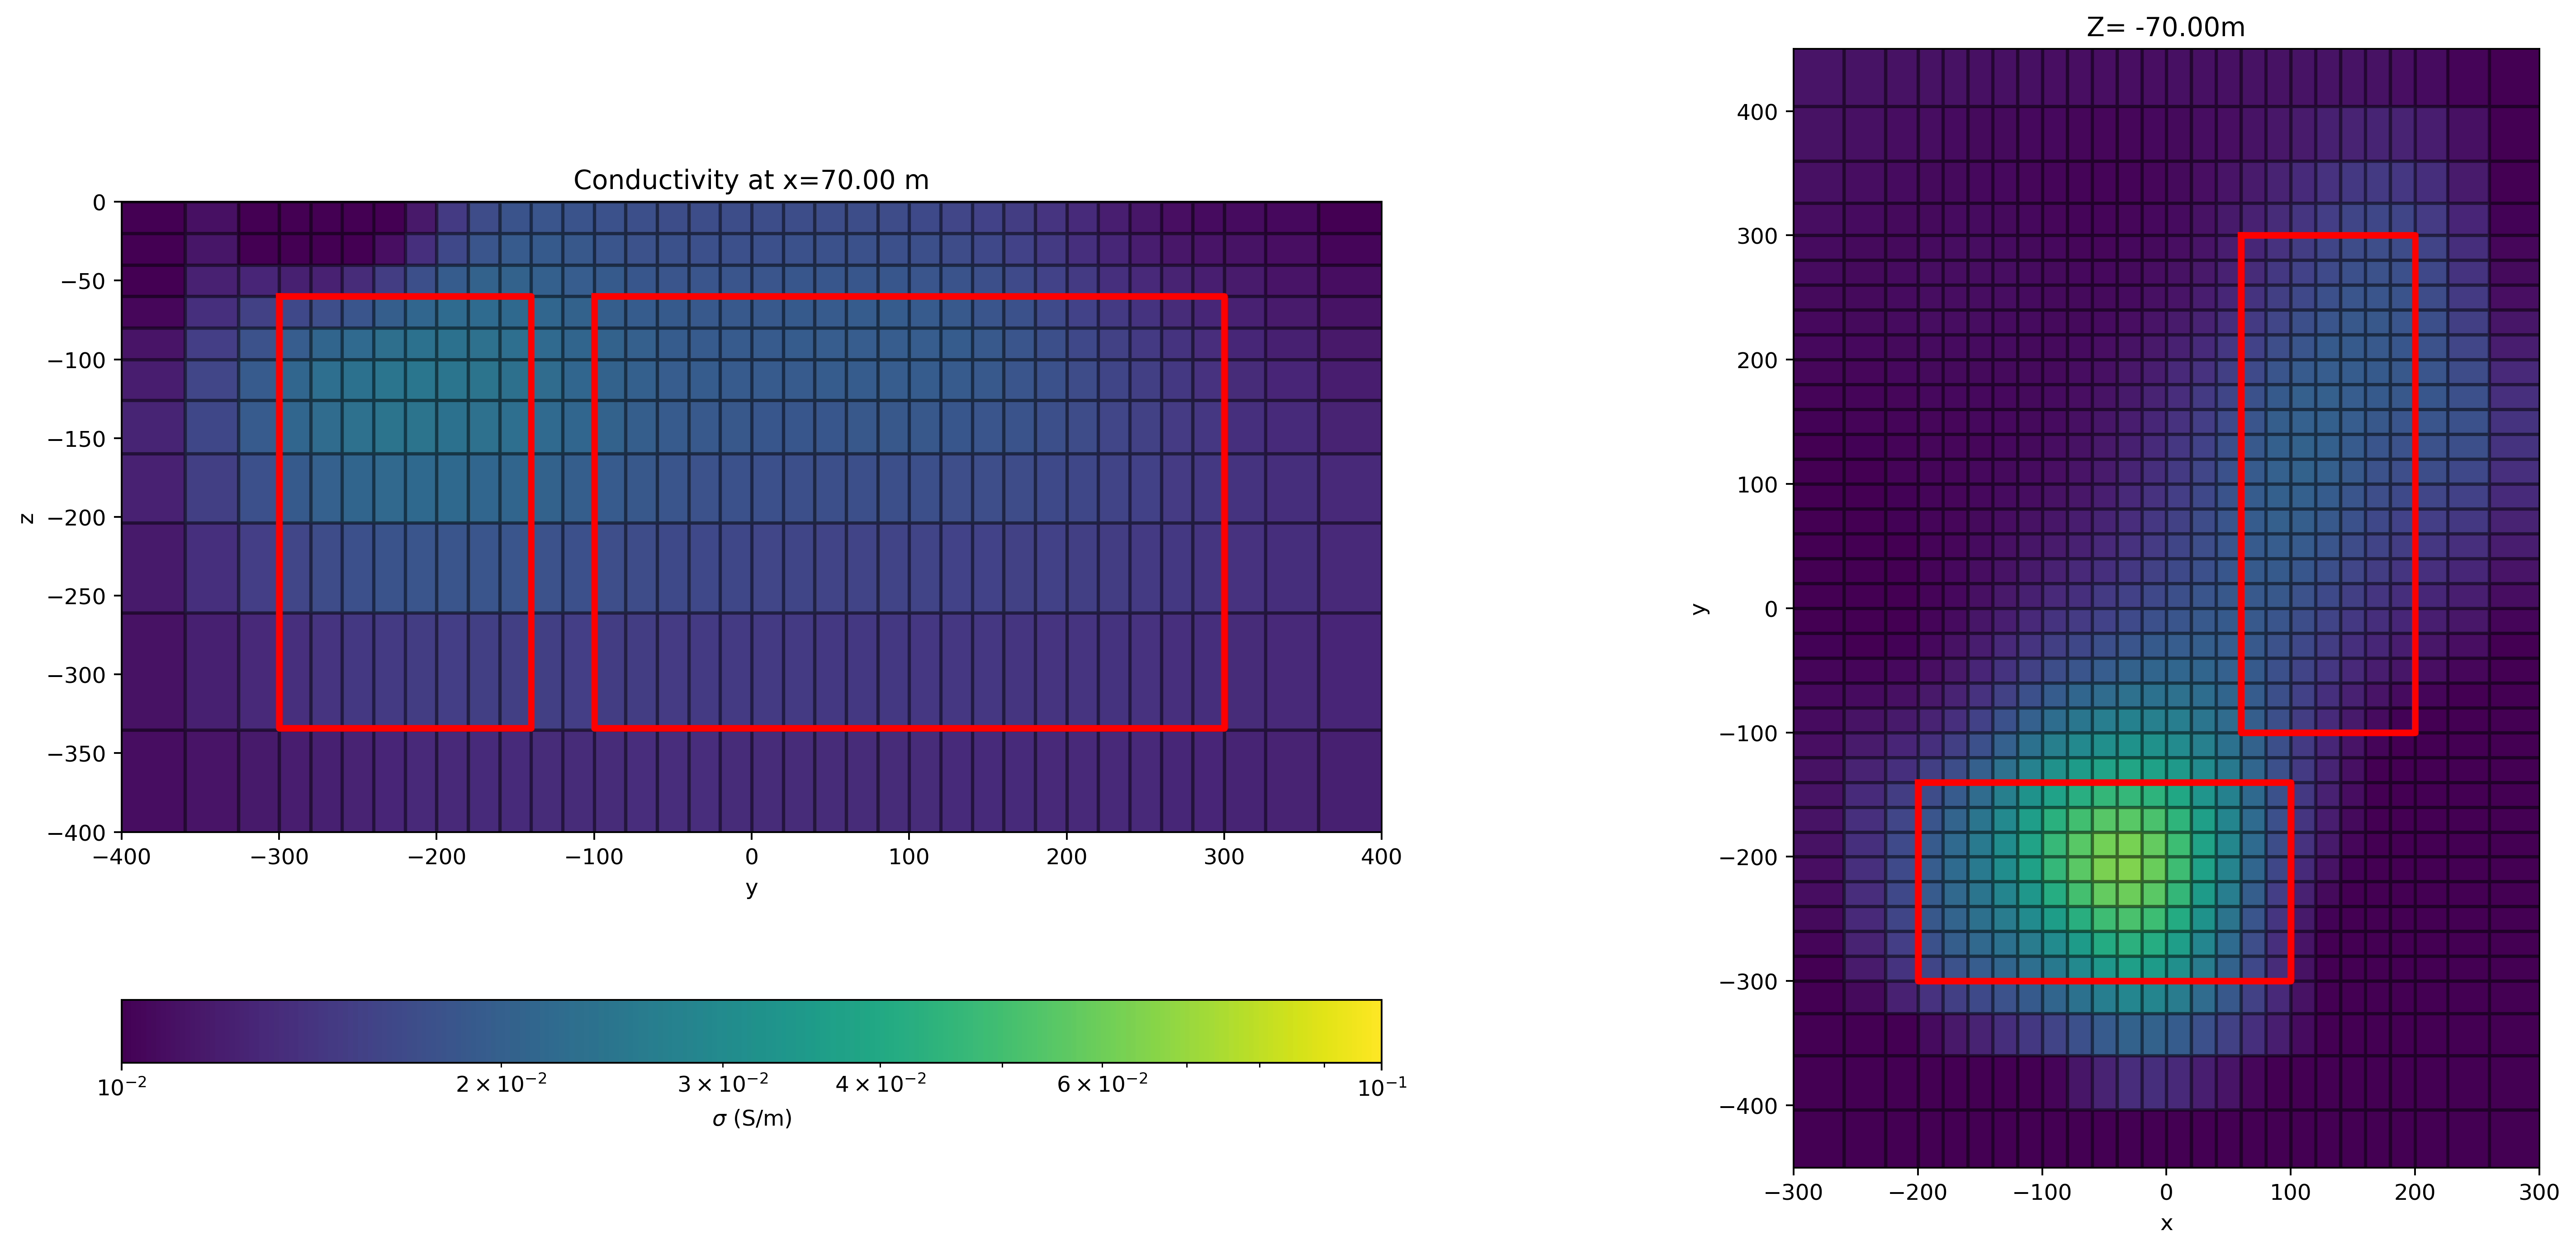

In [5]:
# plot inverted model

# conductivity model parameters
sig_air = 1e-8

# mapping model
actind = mesh.gridCC[:,2]<0.
actmap = maps.InjectActiveCells(mesh, indActive=actind, valInactive=np.log(sig_air))
expmap = maps.ExpMap(mesh)
mapping = maps.ComboMap([expmap, actmap])

tempcp = mapping*np.load('./data/mopt_linecurrent.npy')

indx = 26
indy = 15
indz = 14

fig, ax = plt.subplots(1,2, figsize = (18, 8),dpi=350)

clim = [1e-2, 1e-1]

dat1 = mesh.plotSlice(tempcp, grid=True, ax=ax[0], ind=indx, normal='X' ,pcolorOpts={'norm':LogNorm()}, clim=clim)
dat2 = mesh.plotSlice(tempcp, grid=True, ax=ax[1], ind=indz, pcolorOpts={'norm':LogNorm()}, clim=clim)

fram1 = np.array([[-300,-140,-140,-300,-300],[-60,-60,-334,-334,-60]])
fram2 = np.array([[-100,300,300,-100,-100],[-60,-60,-334,-334,-60]])
ax[0].plot(fram1[0,:],fram1[1,:],color='red',linewidth=3)
ax[0].plot(fram2[0,:],fram2[1,:],color='red',linewidth=3)

fram3 = np.array([[-200,100,100,-200,-200],[-140,-140,-300,-300,-140]])
fram4 = np.array([[60,200,200,60,60],[300,300,-100,-100,300]])
ax[1].plot(fram3[0,:],fram3[1,:],color='red',linewidth=3)
ax[1].plot(fram4[0,:],fram4[1,:],color='red',linewidth=3)

cb = plt.colorbar(dat1[0], orientation="horizontal", ax = ax[0])

ax[0].set_xlim([-400,400])
ax[0].set_ylim([-400,0])
ax[1].set_xlim([-300,300])
ax[1].set_ylim([-450,450])

plt.tight_layout()

ax[0].set_aspect(1)
ax[1].set_aspect(1)

ax[0].set_title("Conductivity at x={:1.2f} m".format(mesh.vectorCCx[indx]))
ax[1].set_title("Z= {:1.2f}m".format(mesh.vectorCCz[indz]))

cb.set_label("$\sigma$ (S/m)")

### Inversion Process

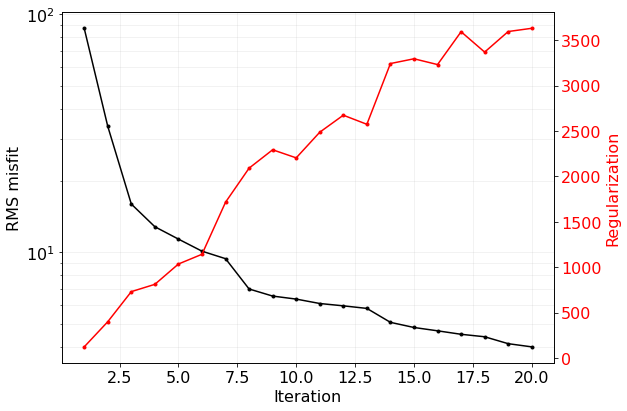

In [13]:
import matplotlib
matplotlib.rcParams['font.size'] = 16

results = np.loadtxt('./data/InversionModel-2021-01-14-12-40.txt')
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax_1 = ax.twinx()
ax.semilogy(results[:,0], np.sqrt(results[:,2]/ (1050/2.)), '.k-')
ax_1.plot(results[:,0], results[:,3], '.r-')
ax.set_xlabel("Iteration")
ax.set_ylabel("RMS misfit")
ax_1.set_ylabel("Regularization", color='red')
for tl in ax_1.get_yticklabels():
    tl.set_color('r')
ax.grid(which='both', alpha=0.2)
plt.tight_layout()

### Data fitting

Text(0.5, 1.0, 'Receiver: X=-300.00m Y=192.86m')

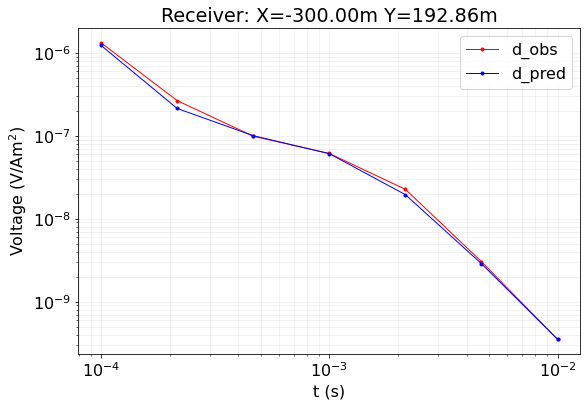

In [39]:
dobs = np.load('./data/dobs_linecurrent.npy')
dobs = dobs.reshape((survey.nSrc, time.size, rx_z.locs[:,0].size))
dpred = np.load('./data/dpred_linecurrent.npy')
dpred = dpred.reshape((survey.nSrc, time.size, rx_z.locs[:,0].size))

i = 100# index of receivers (i=0:149 in this example)
fig = plt.subplots(1,1,figsize=(9, 6))
plt.loglog(time, np.abs(dobs[0,:,i]), 'r.-', lw=1)
plt.loglog(time, np.abs(dpred[0,:,i]), 'b.-', lw=1)
plt.xlabel("t (s)")
plt.ylabel("Voltage (V/Am$^2$)")
plt.grid(which="both", alpha=0.2)
plt.legend(['d_obs','d_pred',])
plt.title('Receiver: X={:1.2f}m Y={:1.2f}m'.format(location_r[i,0],location_r[i,1]))